In [12]:
import os
import requests

In [13]:
dataPath = "C:/Users/Administrator/Desktop/导师/2020 9 22/python代码/"
path = dataPath + "mnist/"

if not os.path.exists(path):
    os.mkdir(path)

URL = "http://deeplearning.net/data/mnist/"
filename="mnist.pkl.gz"

if not os.path.exists(path+filename):
    content = requests.get(URL+filename).content
    with open(path+filename, "wb") as f:
        f.write(content)

In [14]:
import pickle
import gzip

In [15]:
filename2 = "mnist.pkl.gz"

with gzip.open(path+filename2) as f:
    ((x_train, y_train),(x_valid, y_valid),_) = pickle.load(f, encoding='latin1')

(50000, 784)


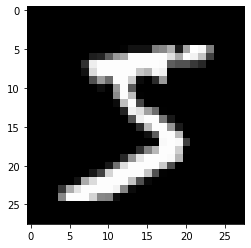

In [16]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28,28)),cmap="gray")
print(x_train.shape)

In [17]:
import torch

x_train,y_train,x_valid,y_valid=map(
    torch.tensor,(x_train,y_train,x_valid,y_valid)
)
n,c=x_train.shape
x_train,x_train.shape,y_train.min(),y_train.max()
print(x_train,y_train)
print(x_train.shape)
print(y_train.min(),y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


torch.nn.functional 很多层和函数在这里都会见到
那么什么时候用nn.Module,什么时候用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module,其他用nn.functional相对更简单

In [18]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights)+bias

In [19]:
bs = 64
xb = x_train[0:bs]
yb = y_train[0:bs]
weights = torch.randn([784,10],dtype=torch.float,requires_grad=True)
bs=64
bias = torch.zeros(10,requires_grad=True)

print(loss_func(model(xb),yb))

tensor(12.7958, grad_fn=<NllLossBackward>)


创建一个model来更简化代码

In [20]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1=nn.Linear(784,128)
        self.hidden2=nn.Linear(128,256)
        self.out=nn.Linear(256,10)
        
    def forward(self,x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x
    

In [21]:
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [22]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train,y_train)
train_dl = DataLoader(train_ds,batch_size=bs,shuffle=True)

valid_ds = TensorDataset(x_valid,y_valid)
valid_dl = DataLoader(train_ds,batch_size=bs*2)

In [24]:
def get_data(train_ds,valid_ds,bs):
    return (
        DataLoader(train_ds,batch_size=bs,shuffle=True),
        DataLoader(valid_ds,batch_size=bs*2)
    )

In [27]:
def loss_batch(model,loss_func,xb,yb,opt=None):
    loss = loss_func(model(xb),yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(),len(xb)

In [34]:
import numpy as np

def fit(steps,model,loss_func,opt,train_dl,valid_dl):
    for step in range(steps):
        model.train()
        for xb,yb in train_dl:
            loss_batch(model,loss_func,xb,yb,opt)
            
        model.eval()
        with torch.no_grad():
            losses,nums=zip(
                *[loss_batch(model,loss_func,xb,yb) for xb,yb in valid_dl]
            )
            val_loss = np.sum(np.multiply(losses,nums))/ np.sum(nums)
            print("当前step:"+str(step),"验证集损失："+str(val_loss))

In [35]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model,optim.SGD(model.parameters(),lr=0.001)

In [36]:
train_dl,valid_dl = get_data(train_ds,valid_ds,bs)
model,opt=get_model()
fit(25,model,loss_func,opt,train_dl,valid_dl)

当前step:0 验证集损失：2.2788135818481443
当前step:1 验证集损失：2.2426248256683348
当前step:2 验证集损失：2.185637297439575
当前step:3 验证集损失：2.090501259613037
当前step:4 验证集损失：1.9344349891662598
当前step:5 验证集损失：1.7089788038253784
当前step:6 验证集损失：1.4480669017791747
当前step:7 验证集损失：1.208360311126709
当前step:8 验证集损失：1.0194493141174317
当前step:9 验证集损失：0.8793843868255615
当前step:10 验证集损失：0.7759933253288269
当前step:11 验证集损失：0.6975239326477051
当前step:12 验证集损失：0.6368100028038025
当前step:13 验证集损失：0.5892513094902039
当前step:14 验证集损失：0.5508791333675385
当前step:15 验证集损失：0.5201240503787994
当前step:16 验证集损失：0.49390952267646787
当前step:17 验证集损失：0.4722702098846436
当前step:18 验证集损失：0.4540692472934723
当前step:19 验证集损失：0.4384575770378113
当前step:20 验证集损失：0.42499508428573607
当前step:21 验证集损失：0.41294923992156984
当前step:22 验证集损失：0.40282913999557496
当前step:23 验证集损失：0.39288691334724424
当前step:24 验证集损失：0.384621440243721
